**Just Ensure that the runtime is set to using t4 gpu and the dtype=float16 is only supported. If not then please change the runtime to t4**

**To save time you could also skip all of this and run end of the notebook :)**

In [ ]:
import torch
import triton
import triton.language as tl
import time
import math
@triton.autotune(
    configs=[
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 64}, num_warps=4, num_stages=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 64}, num_warps=8, num_stages=3),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64}, num_warps=4, num_stages=2),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 128}, num_warps=8, num_stages=2),
        triton.Config({'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 128}, num_warps=8, num_stages=3),
        triton.Config({'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 32}, num_warps=4, num_stages=2),
        #trtion.Config({'BLOCK_M' :64, 'BLOCK_N':128}, num_warps=)
    ],
    key=['N_CTX'],
)
@triton.jit
def flash_attn_v1_fwd_kernel(
    Q, K, V, O, M, L,
    stride_qz, stride_qh, stride_qm, stride_qk,
    stride_kz, stride_kh, stride_kn, stride_kk,
    stride_vz, stride_vh, stride_vn, stride_vk,
    stride_oz, stride_oh, stride_om, stride_ok,
    stride_mz, stride_mh, stride_mm,
    stride_lz, stride_lh, stride_lm,
    Z, H, N_CTX,
    BLOCK_SIZE_M: tl.constexpr,
    BLOCK_SIZE_N: tl.constexpr,
    BLOCK_SIZE_HEAD_DIM: tl.constexpr,
    IF_CAUSAL_MASK: tl.constexpr,
    softmax_scale:tl.constexpr
):
    start_m = tl.program_id(0)
    batch_head_id = tl.program_id(1)

    batch_id = batch_head_id // H
    head_id = batch_head_id % H

    offs_m = start_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_k = tl.arange(0, BLOCK_SIZE_HEAD_DIM)

    q_ptrs = (Q + batch_id * stride_qz + head_id * stride_qh +
              offs_m[:, None] * stride_qm + offs_k[None, :] * stride_qk)

    q_mask = offs_m[:, None] < N_CTX
    q = tl.load(q_ptrs, mask=q_mask, other=0.0)

    # Initialize online softmax variables
    l_i = tl.zeros([BLOCK_SIZE_M], dtype=tl.float32)
    m_i = tl.zeros([BLOCK_SIZE_M], dtype=tl.float32) + float('-inf')
    acc = tl.zeros([BLOCK_SIZE_M, BLOCK_SIZE_HEAD_DIM], dtype=tl.float32)

    #qk_scale = tl.rsqrt(BLOCK_SIZE_HEAD_DIM) # Ensure float type for rsqrt argument


    end_n = N_CTX if not IF_CAUSAL_MASK else (start_m + 1) * BLOCK_SIZE_M

    for start_n in range(0, end_n, BLOCK_SIZE_N):
        offs_n = start_n + tl.arange(0, BLOCK_SIZE_N)

        # Corrected K pointers for transpose: (BLOCK_SIZE_HEAD_DIM, BLOCK_SIZE_N)
        # The strides correspond to the logical layout *after* transpose,
        # so we need to use stride_kn with offs_k and stride_kk with offs_n
        k_ptrs = (K + batch_id * stride_kz + head_id * stride_kh
                   + offs_n[:,None] * stride_kn + offs_k[None,:] * stride_kk )
        #k_ptrs = (K + batch_id * stride_kz + head_id * stride_kh
                   #+  offs_k[:, None] * stride_kk + offs_n[None, :] * stride_kn ) # Swapped strides and offsets

        # V pointers: (BLOCK_SIZE_N, BLOCK_SIZE_HEAD_DIM)
        v_ptrs = (V + batch_id * stride_vz + head_id * stride_vh +
                  offs_n[:, None] * stride_vn + offs_k[None, :] * stride_vk)

        # Mask for K and V loading
        k_mask = offs_n[:, None] < N_CTX
        #k_mask=  offs_n[None,:] <N_CTX # Mask applies to the dimension varying with 'n'
        # V mask
        v_mask = offs_n[:, None] < N_CTX

        # Load K tile (shape will be BLOCK_SIZE_HEAD_DIM x BLOCK_SIZE_N due to pointer layout)
        k = tl.load(k_ptrs, mask=k_mask, other=0.0)
        # Load V tile (shape will be BLOCK_SIZE_N x BLOCK_SIZE_HEAD_DIM)
        v = tl.load(v_ptrs, mask=v_mask, other=0.0)


        # Compute attention scores: Q (M, K) * K^T (K, N) -> (M, N)
        # tl.dot(q, k, trans_b=True) expects k to have shape (K, N) already
        # Since we loaded k with shape (BLOCK_SIZE_HEAD_DIM, BLOCK_SIZE_N),
        # we need to use trans_b=False or simply tl.dot(q, k)
        #qk = tl.dot(q, tl.trans(k), allow_tf32=False) # Use tl.dot(q, k) if k is loaded with shape (K, N)
                          # Or use tl.dot(q, k, trans_b=True) if k is loaded with shape (N, K)
                          # Given our pointer logic for k_ptrs, k is loaded as (K, N)
                          # So, tl.dot(q, k) is correct for (M, K) * (K, N) -> (M, N)
        #tl.debug_barrier()
        #tl.print(“qk tile =”, qk)
        qk = tl.dot(q, tl.trans(k))
        qk*=  softmax_scale

        # Apply causal mask if needed
        if IF_CAUSAL_MASK:
            causal_mask = offs_m[:, None] >= offs_n[None, :]
            qk = tl.where(causal_mask, qk, float('-inf'))

        # Online softmax computation
        m_i_new = tl.maximum(m_i, tl.max(qk, axis=1))
        p_ij = tl.exp(qk - m_i_new[:, None])
        scale = tl.exp(m_i - m_i_new)

        # Update accumulator
        acc = acc * scale[:, None]
        # p_ij (M, N), v (N, K) -> dot (M, K)
        acc += tl.dot(p_ij.to(v.dtype), v) # Removed trans_b=True, dot(A, B) expects B with columns matching A rows

        # Update normalizing factors
        l_i_current = tl.sum(p_ij, axis=1)
        l_i = l_i * scale + l_i_current
        m_i = m_i_new

    # Store outputs
    O_ptrs = (O + batch_id * stride_oz + head_id * stride_oh +
              offs_m[:, None] * stride_om + offs_k[None, :] * stride_ok)
    M_ptrs = (M + batch_id * stride_mz + head_id * stride_mh + offs_m * stride_mm)
    L_ptrs = (L + batch_id * stride_lz + head_id * stride_lh + offs_m * stride_lm)

    acc_o = acc / l_i[:, None]

    o_mask = offs_m[:, None] < N_CTX
    m_mask = offs_m < N_CTX

    tl.store(O_ptrs, acc_o, mask=o_mask)
    tl.store(M_ptrs, m_i, mask=m_mask)
    tl.store(L_ptrs, l_i, mask=m_mask)





In [ ]:
import torch
import triton
import triton.language as tl
import math
@triton.autotune(
    configs=[
        triton.Config({'BLOCK_M': 128}, num_warps=4),
        triton.Config({'BLOCK_M': 256}, num_warps=8),
    ],
    key=['N_CTX'],
)
@triton.jit
def flash_attn_v1_dO_O_bwd_kernel(
    dO, O, Delta,
    stride_dob, stride_doh, stride_dom, stride_dok,
    stride_ob, stride_oh, stride_om, stride_ok,
    stride_db,stride_dh,stride_dm,
    L,
    B, H, N_CTX,
    BLOCK_M:tl.constexpr,
    BLOCK_HEAD_DIM:tl.constexpr
):
    start_m = tl.program_id(0)
    batch_head_id = tl.program_id(1)

    batch_id = batch_head_id // H
    head_id = batch_head_id % H
    offs_m = start_m * BLOCK_M + tl.arange(0, BLOCK_M)
    offs_k = tl.arange(0, BLOCK_HEAD_DIM)

    dO_ptrs = tl.load(dO + batch_id * stride_dob + head_id * stride_doh +
                      offs_m[:, None] * stride_dom + offs_k[None, :] * stride_dok,
                      mask=(offs_m[:, None] < N_CTX),
                      other=0.0).to(tl.float32)

    O_ptrs = tl.load(O + batch_id * stride_ob + head_id * stride_oh +
                     offs_m[:, None] * stride_om + offs_k[None, :] * stride_ok,
                     mask=(offs_m[:, None] < N_CTX),
                     other=0.0).to(tl.float32)

    L_vals = tl.load(L + batch_id*stride_db + head_id*stride_dh + offs_m*stride_dm, mask=offs_m < N_CTX, other=1e-12)

    dO_ptrs_normal = dO_ptrs / L_vals[:, None]

    beta_vals = tl.sum((dO_ptrs_normal * O_ptrs), axis=-1)

    tl.store(dO + batch_id * stride_dob + head_id * stride_doh +
             offs_m[:, None] * stride_dom + offs_k[None, :] * stride_dok, dO_ptrs_normal)
    tl.store(Delta + batch_id * stride_db + head_id * stride_dh + offs_m * stride_dm , beta_vals)


@triton.autotune(
    configs=[
        triton.Config({'BLOCK_M': 64, 'BLOCK_N': 64}, num_warps=4, num_stages=2),
        triton.Config({'BLOCK_M': 32, 'BLOCK_N': 32}, num_warps=4, num_stages=2),
        triton.Config({'BLOCK_M': 64, 'BLOCK_N': 64}, num_warps=8, num_stages=2),
        triton.Config({'BLOCK_M': 32, 'BLOCK_N': 128}, num_warps=8, num_stages=2),
        triton.Config({'BLOCK_M': 32, 'BLOCK_N': 128}, num_warps=4, num_stages=3)
    ],
    key=['N_CTX'],
)
@triton.jit
def flash_attn_bwd_dq_kernel(
    Q, K, V, DO, DQ, L, M, D, softmax_scale,
    stride_qz, stride_qh, stride_qm, stride_qk,
    stride_kz, stride_kh, stride_kn, stride_kk,
    stride_vz, stride_vh, stride_vn, stride_vk,
    stride_doz, stride_doh, stride_dom, stride_dok,
    stride_dqz, stride_dqh, stride_dqm, stride_dqk,
    Z, H, N_CTX, HEAD_DIM,
    BLOCK_M: tl.constexpr, BLOCK_N: tl.constexpr,BLOCK_HEAD_DIM:tl.constexpr
):
    start_m = tl.program_id(0)
    off_hz = tl.program_id(1)

    off_h = off_hz % H
    off_z = off_hz // H

    # Initialize offsets
    offs_m = start_m * BLOCK_M + tl.arange(0, BLOCK_M)
    offs_n = tl.arange(0, BLOCK_N)
    offs_d = tl.arange(0, BLOCK_HEAD_DIM)

    # Load Q, DO for this block
    q_ptrs = (Q + off_z * stride_qz + off_h * stride_qh + offs_m[:, None] * stride_qm + offs_d[None, :] * stride_qk)
    do_ptrs = (DO + off_z * stride_doz + off_h * stride_doh + offs_m[:, None] * stride_dom + offs_d[None, :] * stride_dok)



    q = tl.load(q_ptrs, mask=(offs_m[:, None]<N_CTX) & (offs_d[None ,:]< HEAD_DIM), other=0.0)
    do = tl.load(do_ptrs, mask=(offs_m[:, None]<N_CTX) & (offs_d[None ,:]< HEAD_DIM), other=0.0)

    # Load statistics
    l_ptrs = L + off_hz * N_CTX + offs_m
    m_ptrs = M + off_hz * N_CTX + offs_m
    d_ptrs = D + off_hz * N_CTX + offs_m

    l_i = tl.load(l_ptrs, mask=offs_m < N_CTX, other=1.0)
    m_i = tl.load(m_ptrs, mask=offs_m < N_CTX, other=float('-inf'))
    d_i = tl.load(d_ptrs, mask=offs_m < N_CTX, other=0.0)

    # Initialize dQ accumulator
    dq = tl.zeros([BLOCK_M,BLOCK_HEAD_DIM], dtype=tl.float32)

    # Loop over blocks of K, V
    for start_n in range(0, N_CTX, BLOCK_N):
        offs_n_curr = start_n + offs_n

        # Load K, V
        k_ptrs = (K + off_z * stride_kz + off_h * stride_kh + offs_n_curr[:, None] * stride_kn + offs_d[None, :] * stride_kk)
        v_ptrs = (V + off_z * stride_vz + off_h * stride_vh + offs_n_curr[:, None] * stride_vn + offs_d[None, :] * stride_vk)


        k = tl.load(k_ptrs, mask=(offs_n_curr[:, None]<N_CTX) & (offs_d[None, :] < HEAD_DIM) , other=0.0)
        v = tl.load(v_ptrs,  mask=(offs_n_curr[:, None]<N_CTX) & (offs_d[None, :] < HEAD_DIM) , other=0.0)

        # this is done so the accumulaton stays in 32bit
        #qk = tl.zeros([BLOCK_M, BLOCK_N], dtype=tl.float32)
        qk = tl.dot(q, tl.trans(k))
        qk*=  softmax_scale

        # Apply causal mask
        #causal_mask = offs_m[:, None] >= offs_n_curr[None, :]
        #qk = tl.where(causal_mask, qk, float('-inf'))

        # Compute attention weights
        p = tl.exp(qk - m_i[:, None])


        dp = tl.dot(do, tl.trans(v))
        ds = (p * (dp - d_i[:, None])).to(q.dtype)
        #ds = ds / l_i[:, None]

        ds = ds  * softmax_scale
        # Accumulate dQ
        dq += tl.dot(ds.to(k.dtype), k)

    # Store dQ
    dq_ptrs = (DQ + off_z * stride_dqz + off_h * stride_dqh + offs_m[:, None] * stride_dqm + offs_d[None, :] * stride_dqk)
    tl.store(dq_ptrs, dq, mask=(offs_m[:, None] < N_CTX) & (offs_d[None, :] < HEAD_DIM))

@triton.autotune(
    configs=[
        triton.Config({'BLOCK_M': 64, 'BLOCK_N': 64}, num_warps=4, num_stages=2),
        triton.Config({'BLOCK_M': 32, 'BLOCK_N': 32}, num_warps=4, num_stages=2),
        triton.Config({'BLOCK_M': 64, 'BLOCK_N': 64}, num_warps=8, num_stages=2),
        triton.Config({'BLOCK_M': 32, 'BLOCK_N': 128}, num_warps=8, num_stages=2),
        triton.Config({'BLOCK_M': 32, 'BLOCK_N': 128}, num_warps=4, num_stages=3)
    ],
    key=['N_CTX'],
)
@triton.jit
def flash_attn_bwd_dk_dv_kernel(
    Q, K, V, DO, DK, DV, L, M, D, softmax_scale,
    stride_qz, stride_qh, stride_qm, stride_qk,
    stride_kz, stride_kh, stride_kn, stride_kk,
    stride_vz, stride_vh, stride_vn, stride_vk,
    stride_doz, stride_doh, stride_dom, stride_dok,
    stride_dkz, stride_dkh, stride_dkn, stride_dkk,
    stride_dvz, stride_dvh, stride_dvn, stride_dvk,
    Z, H, N_CTX, HEAD_DIM,
    BLOCK_M: tl.constexpr, BLOCK_N: tl.constexpr,BLOCK_HEAD_DIM:tl.constexpr
):
    start_n = tl.program_id(0)
    off_hz = tl.program_id(1)

    off_h = off_hz % H
    off_z = off_hz // H

    # Initialize offsets
    offs_n = start_n * BLOCK_N + tl.arange(0, BLOCK_N)
    offs_m = tl.arange(0, BLOCK_M)
    offs_d = tl.arange(0, BLOCK_HEAD_DIM)


    # Load K, V for this block
    k_ptrs = K + off_z * stride_kz + off_h * stride_kh + offs_n[:, None] * stride_kn + offs_d[None, :] * stride_kk
    v_ptrs = V + off_z * stride_vz + off_h * stride_vh + offs_n[:, None] * stride_vn + offs_d[None, :] * stride_vk


    mask_kv_load = (offs_n[:, None] < N_CTX) & (offs_d[None, :] < HEAD_DIM)

    k = tl.load(k_ptrs, mask=mask_kv_load, other=0.0)
    v = tl.load(v_ptrs, mask=mask_kv_load, other=0.0)

    # Initialize dK, dV accumulators
    dk = tl.zeros([BLOCK_N,BLOCK_HEAD_DIM], dtype=tl.float32)
    dv = tl.zeros([BLOCK_N,BLOCK_HEAD_DIM], dtype=tl.float32)

    # Loop over blocks of Q, DO
    for start_m in range(0, N_CTX, BLOCK_M):
        offs_m_curr = start_m + offs_m

        # Load Q, DO
        q_ptrs = Q + off_z * stride_qz + off_h * stride_qh + offs_m_curr[:, None] * stride_qm + offs_d[None, :] * stride_qk
        do_ptrs = DO + off_z * stride_doz + off_h * stride_doh + offs_m_curr[:, None] * stride_dom + offs_d[None, :] * stride_dok


        q = tl.load(q_ptrs, mask=offs_m_curr[:, None] < N_CTX, other=0.0)
        do = tl.load(do_ptrs, mask=offs_m_curr[:, None] < N_CTX, other=0.0)

        # Load statistics
        l_ptrs = L + off_hz * N_CTX + offs_m_curr
        m_ptrs = M + off_hz * N_CTX + offs_m_curr
        d_ptrs = D + off_hz * N_CTX + offs_m_curr



        l_i = tl.load(l_ptrs, mask=offs_m_curr < N_CTX, other=0.0)
        m_i = tl.load(m_ptrs, mask=offs_m_curr < N_CTX, other=float('-inf'))
        d_i = tl.load(d_ptrs, mask=offs_m_curr < N_CTX, other=0.0)


        # Compute attention scores
        #qk = tl.zeros([BLOCK_M, BLOCK_N], dtype=tl.float32)
        qk = tl.dot(q, tl.trans(k))
        qk *= softmax_scale

        # Apply causal mask
        #causal_mask = offs_m_curr[:, None] >= offs_n[None, :]
        #qk = tl.where(causal_mask, qk, float('-inf'))

        # Compute attention weights
        p = tl.exp(qk - m_i[:, None])
        #p = p * l_i[:, None]

        # Accumulate dV
        dv += tl.dot(tl.trans(p).to(q.dtype), do)

        # Compute dS and accumulate dK
        dp = tl.dot(do, tl.trans(v))
        ds = (p * (dp - d_i[:, None])).to(q.dtype)
        ds *=  softmax_scale
        dk += tl.dot(tl.trans(ds).to(q.dtype), q)

    # Store dK, dV
    dk_ptrs = DK + off_z * stride_dkz + off_h * stride_dkh + offs_n[:, None] * stride_dkn + offs_d[None, :] * stride_dkk
    dv_ptrs = DV + off_z * stride_dvz + off_h * stride_dvh + offs_n[:, None] * stride_dvn + offs_d[None, :] * stride_dvk

    tl.store(dk_ptrs, dk, mask=(offs_n[:, None] < N_CTX) & (offs_d[None, :] < HEAD_DIM))
    tl.store(dv_ptrs, dv, mask=(offs_n[:, None] < N_CTX) & (offs_d[None, :] < HEAD_DIM))


class Myattention1(torch.autograd.Function):
    @staticmethod
    def forward(ctx, q, k, v, causal=False):

        batch_size, num_heads, seq_len, head_dim = q.shape
        softmax_scale = 1.0 / math.sqrt(head_dim)

        # 2. Create output tensors
        output = torch.empty_like(q)
        # m and l are for the log-sum-exp for backward pass stability
        m = torch.empty((batch_size, num_heads, seq_len), device=q.device, dtype=torch.float32)
        l = torch.empty((batch_size, num_heads, seq_len), device=q.device, dtype=torch.float32)


        grid = lambda meta:(triton.cdiv(seq_len, meta['BLOCK_SIZE_M']) ,batch_size * num_heads)

        #Launch Forward Kernel

        flash_attn_v1_fwd_kernel[grid](
            q, k, v, output, m, l,
            q.stride(0), q.stride(1), q.stride(2), q.stride(3),
            k.stride(0), k.stride(1), k.stride(2), k.stride(3),
            v.stride(0), v.stride(1), v.stride(2), v.stride(3),
            output.stride(0), output.stride(1), output.stride(2), output.stride(3),
            m.stride(0), m.stride(1), m.stride(2),
            l.stride(0), l.stride(1), l.stride(2),
            batch_size, num_heads, seq_len,
            #BLOCK_SIZE_M=block_m,
            #BLOCK_SIZE_N=block_n,
            BLOCK_SIZE_HEAD_DIM=head_dim,
            IF_CAUSAL_MASK=causal,
            softmax_scale=softmax_scale
        )

        ctx.save_for_backward(output, m, l, q, k, v)
        ctx.sm_scale = softmax_scale
        ctx.head_dim = head_dim
        return output

    @staticmethod
    def backward(ctx, do):
        # 1. Retrieve saved tensors and constants
        O, m, l, Q, K, V = ctx.saved_tensors

        softmax_scale = ctx.sm_scale
        #BLOCK_M = ctx.BLOCK_M
        #BLOCK_N = ctx.BLOCK_N
        head_dim = ctx.head_dim
        # causal = ctx.causal # If needed in kernels

        batch, heads, seq_len, _ = Q.shape

        DO = do.contiguous()
        DQ = torch.empty_like(Q)
        DK = torch.empty_like(K)
        DV = torch.empty_like(V)

        Delta = torch.empty_like(l)

        #Preprocess - compute Delta (D)
        grid_preprocess = lambda meta :(triton.cdiv(seq_len, meta['BLOCK_M']), batch * heads)

        flash_attn_v1_dO_O_bwd_kernel[grid_preprocess](
            DO,
            O,
            Delta,
            DO.stride(0), DO.stride(1), DO.stride(2), DO.stride(3),
            O.stride(0), O.stride(1), O.stride(2), O.stride(3),
            Delta.stride(0), Delta.stride(1), Delta.stride(2),
            l, # Often passed to help scaling or masking
            batch, heads, seq_len,
            #BLOCK_M=BLOCK_M,
            BLOCK_HEAD_DIM=head_dim
        )


        # Grid often matches the forward grid structure
        grid_dq = lambda meta :(triton.cdiv(seq_len, meta['BLOCK_M']),
                                batch * heads)

        flash_attn_bwd_dq_kernel[grid_dq](
            Q, K, V, DO, DQ, l, m, Delta, softmax_scale,
            Q.stride(0), Q.stride(1), Q.stride(2), Q.stride(3),
            K.stride(0), K.stride(1), K.stride(2), K.stride(3),
            V.stride(0), V.stride(1), V.stride(2), V.stride(3),
            DO.stride(0), DO.stride(1), DO.stride(2), DO.stride(3),
            DQ.stride(0), DQ.stride(1), DQ.stride(2), DQ.stride(3),
            batch, heads, seq_len, head_dim,
            #BLOCK_M=BLOCK_M,
            #BLOCK_N=BLOCK_N,
            BLOCK_HEAD_DIM=head_dim
        )

        #grid_dkv = (triton.cdiv(seq_len, BLOCK_N), batch * heads)
        grid_dkv = lambda meta :(triton.cdiv(seq_len, meta['BLOCK_N']),
                                batch * heads)
        flash_attn_bwd_dk_dv_kernel[grid_dkv](
            Q, K, V, DO, DK, DV, l, m, Delta, softmax_scale,
            Q.stride(0), Q.stride(1), Q.stride(2), Q.stride(3),
            K.stride(0), K.stride(1), K.stride(2), K.stride(3),
            V.stride(0), V.stride(1), V.stride(2), V.stride(3),
            DO.stride(0), DO.stride(1), DO.stride(2), DO.stride(3),
            DK.stride(0), DK.stride(1), DK.stride(2), DK.stride(3),
            DV.stride(0), DV.stride(1), DV.stride(2), DV.stride(3),
            batch, heads, seq_len, head_dim,
            #BLOCK_M=BLOCK_M,
            #BLOCK_N=BLOCK_N,
            BLOCK_HEAD_DIM=head_dim
        )
        return DQ, DK, DV, None, None, None





**Note when you get the seq len and you dont want the autotune to run you can just uncomment and use this code for referral**

In [ ]:
#EXAMPLE CODE
#best_config = flash_attn_v1_fwd_kernel.best_config
#print(f'Best config for the forward kerenl was {best_config}')

In [ ]:
import triton
import triton.language as tl
import torch
import math

@triton.autotune(
    configs=[
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 64}, num_warps=4, num_stages=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 64}, num_warps=8, num_stages=3),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64}, num_warps=4, num_stages=2),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 128}, num_warps=8, num_stages=2),
        triton.Config({'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 128}, num_warps=8, num_stages=3),
    ],
    key=['N_CTX'],
)
# Some basic thing stride are basically how many values to shift to get to the next dim since in CUDA the matrix assumes as row-major format
# That the matrix is laid out in the memory in row-column major so for example for a tensor of shape(3,4) its stride(0) would be 4 and stride(1) would be 1
@triton.jit
def flash_attn_v2_fwd_kernel(
    Q, K, V, O, LSE,
    stride_qz, stride_qh, stride_qm, stride_qk,
    stride_kz, stride_kh, stride_kn, stride_kk,
    stride_vz, stride_vh, stride_vn, stride_vk,
    stride_oz, stride_oh, stride_om, stride_ok,
    stride_lse_z, stride_lse_h, stride_lse_m,
    Z, H, N_CTX, D_HEAD,        # z here represents the batch_id and N_CTX is nothing but the seq_len
    SOFTMAX_SCALE,
    BLOCK_SIZE_M: tl.constexpr, #tl.constexpr means that the triton compiler will get the values at compile time
    BLOCK_SIZE_N: tl.constexpr,
    BLOCK_SIZE_K: tl.constexpr,
    IF_CAUSAL_MASK: tl.constexpr,
):

    # Loading the indcies of batch and head and axis
    start_m = tl.program_id(axis=0)
    batch_head_id = tl.program_id(axis=1) # Batch and Head index combined since b*h can easily be covered by unique p_id

    # Loadin the indcies of batch and head
    batch_id = batch_head_id // H
    head_id = batch_head_id % H

    # Row offsets for the Q block (BLOCK_SIZE_M rows)
    offs_m = start_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    # Head dimension offsets (BLOCK_SIZE_K columns, which is D_HEAD)
    offs_k = tl.arange(0, BLOCK_SIZE_K)

    # Q pointers: Shape (BLOCK_SIZE_M, BLOCK_SIZE_K)
    q_ptrs = (Q + batch_id * stride_qz + head_id * stride_qh +
              offs_m[:, None] * stride_qm + offs_k[None, :] * stride_qk)

    # K/V base pointers for the current batch and head
    k_base_ptr = K + batch_id * stride_kz + head_id * stride_kh
    v_base_ptr = V + batch_id * stride_vz + head_id * stride_vh


    # Accumulator for the output O = Softmax(QK^T)V
    # Needs to be float32 for precision
    acc = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_K), dtype=tl.float32)

    # Max value encountered so far per row: m_i
    m_i = tl.zeros((BLOCK_SIZE_M,), dtype=tl.float32) - float('inf') # Initialize max to -inf
    # Sum of exp(x - max) encountered so far per row: l_i
    l_i = tl.zeros((BLOCK_SIZE_M,), dtype=tl.float32) # Initialize sum to 0

    # Scale factor for QK^T (usually 1 / sqrt(D_HEAD)) This not working so better to
    #qk_scale = tl.rsqrt(D_HEAD.to(tl.float32))

    # --- Load Q Tile ---
    # Load Q for the current block row (offs_m)
    # Boundary check for Q rows (sequence length N_CTX)
    q_mask = offs_m[:, None] < N_CTX

    # Note the q_ptrs will be stored in sram for the full loop duration or for one p_id
    # Note the we could also have added offs_k[None, :]<D_HEAD but didnt since we want it to be fixed length
    q = tl.load(q_ptrs, mask=q_mask, other=0.0) # Shape: (BLOCK_SIZE_M, BLOCK_SIZE_K)



    # We need all K/V blocks
    end_n = N_CTX
    if IF_CAUSAL_MASK:
      # K/V blocks should end where Q block ends
      # For token i (row in Q), we only attend to tokens j <= i (columns in K/V)
      end_n = (start_m + 1) * BLOCK_SIZE_M

    # --- Loop over K/V Blocks (Columns of QK^T matrix) ---
    for start_n in range(0, end_n, BLOCK_SIZE_N):
        # Loadin the K/V tiles since we are looping them over for one p_id
        # Column offsets for the current K/V block (BLOCK_SIZE_N columns)
        offs_n = start_n + tl.arange(0, BLOCK_SIZE_N)

        # K pointers: Shape (BLOCK_SIZE_K, BLOCK_SIZE_N)
        #Since S=QK^T so we already loaded the K in the abovesaid dimension
        k_ptrs = (k_base_ptr +
                  offs_k[:, None] * stride_kk + offs_n[None ,:] * stride_kn )
        # V pointers: Shape (BLOCK_SIZE_N, BLOCK_SIZE_K)
        v_ptrs = (v_base_ptr +
                  offs_n[:, None] * stride_vn + offs_k[None, :] * stride_vk)

        # Boundary check masks for K and V tiles
        # K mask depends on N_CTX for columns (offs_n)
        k_mask = (offs_n[None ,:] < N_CTX)
        # V mask depends on N_CTX for rows (offs_n)
        v_mask = (offs_n[:, None] < N_CTX)

        # Load K tile (transposed layout for dot product)
        k = tl.load(k_ptrs, mask=k_mask, other=0.0) # Shape: (BLOCK_SIZE_K, BLOCK_SIZE_N)
        # Load V tile
        v = tl.load(v_ptrs, mask=v_mask, other=0.0) # Shape: (BLOCK_SIZE_N, BLOCK_SIZE_K)

        # --- Compute QK^T Score Block ---
        # q shape: (BLOCK_SIZE_M, BLOCK_SIZE_K)
        # k shape: (BLOCK_SIZE_K, BLOCK_SIZE_N)
        #qk = tl.zeros([BLOCK_M, BLOCK_N], dtype=tl.float32)
        qk = tl.dot(q, k) # Shape: (BLOCK_SIZE_M, BLOCK_SIZE_N)


        # --- Apply Causal Mask (if enabled) ---
        if IF_CAUSAL_MASK:
            # Create mask where q_row_index >= k_col_index
            # offs_m are row indices, offs_n are column indices
            causal_mask = offs_m[:, None] >= offs_n[None, :]
            # Apply mask: Set scores for future tokens to negative infinity
            qk = tl.where(causal_mask, qk, -float('inf'))

        qk_scale= 1.44269504089  * SOFTMAX_SCALE  # 1/ln(2)=1.44269...  used for exp2 as we have written since on triton 2^x is much faster
        qk *= qk_scale # Apply scaling factor

        # --- Online Softmax Calculation ---
        # Since the whole Softmax matrix cant be stored as we havent seen the whole columns for K
        # 1. Find the new maximum across the block's scores and the old maximum
        m_i_new = tl.maximum(m_i, tl.max(qk, axis=1)) # Shape: (BLOCK_SIZE_M,)

        # 2. Calculate probabilities P_ij = exp(qk_ij - m_i_new)
        # IMP: Subtracting the new max prevents overflow
        p_ij = tl.exp2(qk - m_i_new[:, None]) # Shape: (BLOCK_SIZE_M, BLOCK_SIZE_N)

        # 3. Calculate scaling factor for previous accumulator and l_i
        # scale = exp(m_i_old - m_i_new)
        scale = tl.exp2(m_i - m_i_new) # Shape: (BLOCK_SIZE_M,)

        # 4. Rescale previous accumulator: acc = acc * scale
        acc = acc * scale[:, None] # Shape: (BLOCK_SIZE_M, BLOCK_SIZE_K)

        # 5. Update accumulator: acc = acc + P_ij @ V_j
        # p_ij shape: (BLOCK_SIZE_M, BLOCK_SIZE_N)
        # v shape: (BLOCK_SIZE_N, BLOCK_SIZE_K)
        # Ensure matching types for dot product
        acc += tl.dot(p_ij.to(v.dtype), v)

        # 6. Update the sum denominator: l_i = l_i * scale + sum(P_ij, axis=1)
        # Calculate block sum: l_i_current = sum(P_ij, axis=1)
        l_i_current = tl.sum(p_ij, axis=1) # Shape: (BLOCK_SIZE_M,)
        # Rescale previous l_i and add current block's contribution
        l_i = l_i * scale + l_i_current # Shape: (BLOCK_SIZE_M,)
        # Why axis 1 because we want it be stored per column
        # 7. Update running max for next iteration: m_i = m_i_new
        m_i = m_i_new
       #Repeat till we havent seen the entire col matrix



    # LSE = m_i + log2(l_i)
    # We dont store the whole m_i and l_i as we will do in the v1 version we just use LSE:log_sum_exponential
    log2_l_i = tl.log2(l_i) # why log2 since its faster
    lse_final = m_i + log2_l_i # Shape: (BLOCK_SIZE_M,)


    #Divide it by the sum we encountered
    acc_o = acc * 1/l_i[:, None] # Shape: (BLOCK_SIZE_M, BLOCK_SIZE_K)

    # 3. Store Output O
    # Output pointers: Shape (BLOCK_SIZE_M, BLOCK_SIZE_K)
    o_ptrs = (O + batch_id * stride_oz + head_id * stride_oh +
              offs_m[:, None] * stride_om + offs_k[None, :] * stride_ok)
    # Boundary check mask for O (same as Q mask for rows, implicit for cols)
    o_mask = offs_m[:, None] < N_CTX
    # Store the result (convert to output dtype if necessary)
    tl.store(o_ptrs, acc_o.to(Q.dtype.element_ty), mask=o_mask)

    # 4. Store LogSumExp (LSE)
    # LSE pointers: Shape (BLOCK_SIZE_M,)
    lse_ptrs = (LSE + batch_id * stride_lse_z + head_id * stride_lse_h +
                offs_m * stride_lse_m)
    # Boundary check mask for LSE rows
    lse_mask = offs_m < N_CTX
    # Store LSE
    tl.store(lse_ptrs, lse_final, mask=lse_mask)


**Now note since the non atomic one is slow as compared to atomic one we will reuse forward and single compute kernel**

In [ ]:
@triton.autotune(
    configs=[
        triton.Config({'BLOCK_SIZE_M': 128}, num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 256}, num_warps=8),
    ],
    key=['N_CTX'],
)
@triton.jit
def _backward_single_kernel(
    Do_ptr, O_ptr, Delta_ptr, H,

    N_CTX, HEAD_DIM: tl.constexpr,
    stride_dob, stride_doh, stride_don, stride_do_head,
    stride_ob, stride_oh, stride_on, stride_o_head,
    BLOCK_SIZE_M: tl.constexpr
):

    start_m = tl.program_id(0)
    batch_row_head = tl.program_id(1)
    offs_m = start_m*BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)

    batch_row = batch_row_head // H
    row_head  = batch_row_head % H

    O_ptrs = O_ptr + stride_ob*batch_row + stride_oh*row_head
    Do_ptrs = Do_ptr + stride_dob*batch_row + stride_doh*row_head

    p_o = tl.make_block_ptr(
        base=O_ptrs,
        shape=(N_CTX, HEAD_DIM),
        strides=(stride_on, stride_o_head),
        offsets=(start_m * BLOCK_SIZE_M, 0),
        block_shape=(BLOCK_SIZE_M, HEAD_DIM),
        order=(1, 0)
    )

    p_do = tl.make_block_ptr(
        base=Do_ptrs,
        shape=(N_CTX, HEAD_DIM),
        strides=(stride_don, stride_do_head),
        offsets=(start_m * BLOCK_SIZE_M, 0),
        block_shape=(BLOCK_SIZE_M, HEAD_DIM),
        order=(1, 0)
    )


    b_o = tl.load(p_o, boundary_check=(0, 1), padding_option="zero")
    b_do = tl.load(p_do, boundary_check=(0, 1), padding_option="zero")

    delta = tl.sum(b_o.to(tl.float32) * b_do.to(tl.float32), axis=1)

    delta_offs = Delta_ptr + batch_row_head * N_CTX + offs_m
    tl.store(delta_offs, delta, mask= offs_m< N_CTX)

In [ ]:
@triton.autotune(
    configs=[
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64}, num_warps=4, num_stages=2),
        triton.Config({'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 32}, num_warps=4, num_stages=2),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64}, num_warps=8, num_stages=2),
        triton.Config({'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 128}, num_warps=8, num_stages=2),
        triton.Config({'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 128}, num_warps=4, num_stages=3),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64}, num_warps=4, num_stages=2),
        triton.Config({'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 32}, num_warps=4, num_stages=2),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64}, num_warps=8, num_stages=2),
        triton.Config({'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 128}, num_warps=8, num_stages=2),
        triton.Config({'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 128}, num_warps=4, num_stages=3)
    ],
    key=['N_CTX'],
)
@triton.jit
def _backward_for_do_dk_dv(
    q_ptr, k_ptr, v_ptr, do_ptr, H,
    dq_ptr, dk_ptr, dv_ptr,
    lse_ptr, delta_ptr,
    # Strides (Input)
    stride_qb, stride_qh, stride_qn, stride_qk,
    stride_kb, stride_kh, stride_kn, stride_kk,
    stride_vb, stride_vh, stride_vn, stride_vk,
    stride_dob, stride_doh, stride_don, stride_dok,
    # Strides (Output)
    stride_dqb, stride_dqh, stride_dqn, stride_dqk,
    stride_dkb, stride_dkh, stride_dkn, stride_dkk,
    stride_dvb, stride_dvh, stride_dvn, stride_dvk,
    # Constants
    N_CTX, HEAD_DIM: tl.constexpr,
    sm_scale: tl.constexpr,
    BLOCK_SIZE_M: tl.constexpr,
    BLOCK_SIZE_N: tl.constexpr,
    LOG2_E: tl.constexpr
):

    start_n = tl.program_id(0)
    batch_row_head = tl.program_id(1)
    offs_n = start_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    offs_m = tl.arange(0, BLOCK_SIZE_M)
    offs_d = tl.arange(0, HEAD_DIM)

    batch_row = batch_row_head // H
    row_head  = batch_row_head % H

    q_ptrs = (q_ptr + batch_row * stride_qb + row_head * stride_qh)
    k_ptrs = (k_ptr + batch_row * stride_kb + row_head * stride_kh)
    v_ptrs = (v_ptr + batch_row * stride_vb + row_head * stride_vh)
    do_ptrs = (do_ptr + batch_row * stride_dob + row_head * stride_doh)
    dq_ptrs = (dq_ptr + batch_row * stride_dqb + row_head * stride_dqh )

    #l_ptrs = lse_ptr + batch_row_head * N_ctx
    #d_ptrs = delta_ptr + batch_row_head * N_ctx
    #contiguous

    #dq_ptr = tl.zeros([BLOCK_SIZE_M, BLOCK_SIZE_HEAD], dtype=tl.float32)
    dv  = tl.zeros([BLOCK_SIZE_N, HEAD_DIM], dtype=tl.float32)
    dk = tl.zeros([BLOCK_SIZE_N, HEAD_DIM], dtype=tl.float32)

    Q_ptr = tl.make_block_ptr(
            base=q_ptrs,
            shape=(N_CTX, HEAD_DIM),
            strides=(stride_qn, stride_qk),
            offsets=(0, 0),
            block_shape=(BLOCK_SIZE_M, HEAD_DIM),
            order=(1, 0)
        )
    dO_ptr = tl.make_block_ptr(
            base=do_ptrs,
            shape=(N_CTX, HEAD_DIM),
            strides=(stride_don, stride_dok),
            offsets=(0, 0),
            block_shape=(BLOCK_SIZE_M, HEAD_DIM),
            order=(1, 0)
        )
    K_ptr = tl.make_block_ptr(
             base = k_ptrs,
             shape = (N_CTX, HEAD_DIM),
             strides = (stride_kn, stride_kk),
             offsets = (start_n * BLOCK_SIZE_N, 0),
             block_shape = (BLOCK_SIZE_N, HEAD_DIM),
             order = (1, 0)
    )
    V_ptr = tl.make_block_ptr(
        base = v_ptrs,
        shape = (N_CTX, HEAD_DIM),
        strides = (stride_vn, stride_vk),
        offsets = (start_n * BLOCK_SIZE_N, 0),
        block_shape = (BLOCK_SIZE_N, HEAD_DIM),
        order = (1, 0)
    )
    k = tl.load(K_ptr, boundary_check=(0, 1), padding_option="zero")
    v = tl.load(V_ptr, boundary_check=(0, 1), padding_option="zero")
    #tl.load(lse, mask = (offs_m[:, None] < N_ctx), others = 1e-6)

    for start_m in range(0, N_CTX, BLOCK_SIZE_M):

       offs_curr_m = start_m + offs_m

       l_ptrs = lse_ptr + batch_row_head * N_CTX + offs_curr_m
       d_ptrs = delta_ptr + batch_row_head * N_CTX + offs_curr_m

       q = tl.load(Q_ptr, boundary_check=(0, 1),padding_option="zero" )
       dO = tl.load(dO_ptr, boundary_check=(0, 1), padding_option="zero")
       lse = tl.load(l_ptrs, mask = offs_curr_m  < N_CTX, other = 0.0)
       D_i = tl.load(d_ptrs, mask = offs_curr_m < N_CTX, other = 0.0)

        #Note you will generate if seq_len isnt power of just mask the k column and q column then -inf
       qk = tl.dot(q, tl.trans(k))
       #mask = offs_curr_m < N_ctx
       #qk = tl.where(mask[None, :], qk, float("-inf"))

       p = tl.exp2((qk * sm_scale * LOG2_E ) - lse[:, None]) # since in the lse is stored in log base 2 we will muplity it with scale factor ln(a) = ln(2)*log2(a)

       dv += tl.dot(tl.trans(p).to(tl.float16), dO)
       dp = tl.dot(dO, tl.trans(v))
       ds = (p * (dp - D_i[:, None]) * sm_scale ).to(q.dtype)
       #ds = (p * dp * sm_scale).to(q.dtype)
       #ds *= sm_scale
       #tl.debug_barrier()
       dq = tl.dot(ds, k)

       dq_curr = offs_curr_m[:, None] * stride_dqn + offs_d[None, :] * stride_dqk


       #tl.debug_barrier()
       tl.atomic_add(dq_ptrs + dq_curr, dq, mask=(offs_curr_m[:, None] < N_CTX))
       tl.debug_barrier()
       dk += tl.dot(tl.trans(ds), q)

       Q_ptr = tl.advance(Q_ptr, offsets=(BLOCK_SIZE_M, 0))
       dO_ptr = tl.advance(dO_ptr, offsets=(BLOCK_SIZE_M, 0))

    dk_ptrs = dk_ptr + batch_row * stride_dkb + row_head * stride_dkh + offs_n[:, None] * stride_dkn + offs_d[None, :] * stride_dkk
    dv_ptrs = dv_ptr + batch_row * stride_dvb + row_head * stride_dvh + offs_n[:, None] * stride_dvn + offs_d[None, :] * stride_dvk

    tl.store(dk_ptrs, dk, mask=(offs_n[:, None] < N_CTX))
    tl.store(dv_ptrs, dv, mask=(offs_n[:, None] < N_CTX))



In [ ]:
class Myattention2(torch.autograd.Function):
    @staticmethod
    def forward(ctx, q, k, v, causal=False):
        # Input shapes and setup
        BATCH, N_HEADS, N_CTX, HEAD_DIM = q.shape
        sm_scale = 1.0 / math.sqrt(HEAD_DIM)
        Z = BATCH
        D_HEAD = HEAD_DIM
        H = N_HEADS
        # Create output tensors
        o = torch.empty_like(q)
        lse = torch.empty((BATCH, N_HEADS, N_CTX), device=q.device, dtype=torch.float32)
        #num_m_blocks = triton.cdiv(N_CTX, block_m)
        #num_bh_groups = BATCH * H #See that why we / and then for head %

        BLOCK_SIZE_K = HEAD_DIM
        grid = lambda meta :(
            triton.cdiv(N_CTX, meta['BLOCK_SIZE_M']),
            BATCH * H
        )
        #grid = (num_m_blocks, num_bh_groups)

        flash_attn_v2_fwd_kernel[grid](
            q, k, v, o, lse,
            q.stride(0), q.stride(1), q.stride(2), q.stride(3),
            k.stride(0), k.stride(1), k.stride(2), k.stride(3),
            v.stride(0), v.stride(1), v.stride(2), v.stride(3),
            o.stride(0), o.stride(1), o.stride(2), o.stride(3),
            lse.stride(0), lse.stride(1), lse.stride(2),
            BATCH, N_HEADS, N_CTX, HEAD_DIM,
            SOFTMAX_SCALE=sm_scale,
            #BLOCK_SIZE_M=block_m,
            #BLOCK_SIZE_N=block_n,
            BLOCK_SIZE_K=BLOCK_SIZE_K,
            IF_CAUSAL_MASK=causal,
            #num_warps=4, # Example, tune based on block sizes and hardware
            #num_stages=2 # Example, tune based on block sizes and hardware
        )

        ctx.save_for_backward(q, k, v, o, lse)
        ctx.sm_scale = sm_scale
        #ctx.BLOCK_M = block_m
        #ctx.BLOCK_N = block_n
        return o
    @staticmethod
    def backward(ctx, do):
        q, k, v, o, lse = ctx.saved_tensors
        #q, k, v, o = ctx.saved_tensors
        #lse = torch.zeros(q.shape(0), q.shape(1), q.shape(2))
        sm_scale = ctx.sm_scale
        #Assume contiguos
        do = do.contiguous()
        BATCH, N_HEADS, N_CTX, HEAD_DIM = q.shape

        # 2. Prepare Output Gradients
        dq = torch.zeros_like(q)
        dk = torch.empty_like(k)
        dv = torch.empty_like(v)
        #Make Delta
        delta = torch.empty_like(lse)

        # Define block sizes
        #BLOCK_M = 32
        #BLOCK_N = 32

        grid_delta = lambda meta: (
            triton.cdiv(N_CTX, meta['BLOCK_SIZE_M']),
            BATCH * N_HEADS
        )
        #grid_delta = (triton.cdiv(N_CTX, BLOCK_M), BATCH * N_HEADS)

        _backward_single_kernel[grid_delta](
            Do_ptr=do,
            O_ptr=o,
            Delta_ptr=delta,
            H=N_HEADS,
            N_CTX=N_CTX,
            HEAD_DIM=HEAD_DIM,
            # Strides for do
            stride_dob=do.stride(0), stride_doh=do.stride(1),
            stride_don=do.stride(2), stride_do_head=do.stride(3),
            # Strides for o
            stride_ob=o.stride(0), stride_oh=o.stride(1),
            stride_on=o.stride(2), stride_o_head=o.stride(3),
            #BLOCK_SIZE_M=BLOCK_M
        )


        #grid_main = (triton.cdiv(N_CTX, BLOCK_N), BATCH * N_HEADS)
        grid_main = lambda meta: (
            triton.cdiv(N_CTX, meta['BLOCK_SIZE_N']),
            BATCH * N_HEADS
        )
        _backward_for_do_dk_dv[grid_main](
            q_ptr=q, k_ptr=k, v_ptr=v, do_ptr=do, H=N_HEADS,
            dq_ptr=dq, dk_ptr=dk, dv_ptr=dv,
            lse_ptr=lse, delta_ptr=delta,

            # Input Strides
            stride_qb=q.stride(0), stride_qh=q.stride(1), stride_qn=q.stride(2), stride_qk=q.stride(3),
            stride_kb=k.stride(0), stride_kh=k.stride(1), stride_kn=k.stride(2), stride_kk=k.stride(3),
            stride_vb=v.stride(0), stride_vh=v.stride(1), stride_vn=v.stride(2), stride_vk=v.stride(3),
            stride_dob=do.stride(0), stride_doh=do.stride(1), stride_don=do.stride(2), stride_dok=do.stride(3),

            # Output Strides
            stride_dqb=dq.stride(0), stride_dqh=dq.stride(1), stride_dqn=dq.stride(2), stride_dqk=dq.stride(3),
            stride_dkb=dk.stride(0), stride_dkh=dk.stride(1), stride_dkn=dk.stride(2), stride_dkk=dk.stride(3),
            stride_dvb=dv.stride(0), stride_dvh=dv.stride(1), stride_dvn=dv.stride(2), stride_dvk=dv.stride(3),

            # Constants
            N_CTX=N_CTX,
            HEAD_DIM=HEAD_DIM,
            sm_scale=sm_scale,
            #BLOCK_SIZE_M=BLOCK_M,
            #BLOCK_SIZE_N=BLOCK_N,
            LOG2_E=1.44269504089 # math.log2(math.e)
        )

        return dq, dk, dv, None, None, None


**Note the above section is using atomic add on float16 which is slower than the v2 version**

**The below section will show you non atomic one we will use two kernel since it now split for dq and dk, dv for one kernel**

In [ ]:
@triton.autotune(
    configs=[
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64}, num_warps=4, num_stages=2),
        triton.Config({'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 32}, num_warps=4, num_stages=2),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64}, num_warps=8, num_stages=2),
        triton.Config({'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 128}, num_warps=8, num_stages=2),
        triton.Config({'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 128}, num_warps=4, num_stages=3),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64}, num_warps=4, num_stages=2),
        triton.Config({'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 32}, num_warps=4, num_stages=2),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64}, num_warps=8, num_stages=2),
        triton.Config({'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 128}, num_warps=8, num_stages=2),
        triton.Config({'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 128}, num_warps=4, num_stages=3)
    ],
    key=['N_CTX'],
)
@triton.jit
def _backward_for_dq(
    q_ptr, k_ptr, v_ptr, do_ptr, H,
    dq_ptr,
    lse_ptr, delta_ptr,
    # Strides (Input)
    stride_qb, stride_qh, stride_qn, stride_qk,
    stride_kb, stride_kh, stride_kn, stride_kk,
    stride_vb, stride_vh, stride_vn, stride_vk,
    stride_dob, stride_doh, stride_don, stride_dok,
    # Strides (Output)
    stride_dqb, stride_dqh, stride_dqn, stride_dqk,
    #stride_dkb, stride_dkh, stride_dkn, stride_dkk,
    #stride_dvb, stride_dvh, stride_dvn, stride_dvk,
    # Constants
    N_CTX, HEAD_DIM: tl.constexpr,
    sm_scale: tl.constexpr,
    BLOCK_SIZE_M: tl.constexpr,
    BLOCK_SIZE_N: tl.constexpr,
    LOG2_E: tl.constexpr
):

    start_m = tl.program_id(0)
    batch_row_head = tl.program_id(1)
    offs_m = start_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_n = tl.arange(0, BLOCK_SIZE_N)
    offs_d = tl.arange(0, HEAD_DIM)

    batch_row = batch_row_head // H
    row_head  = batch_row_head % H

    q_ptrs = (q_ptr + batch_row * stride_qb + row_head * stride_qh)
    k_ptrs = (k_ptr + batch_row * stride_kb + row_head * stride_kh)
    v_ptrs = (v_ptr + batch_row * stride_vb + row_head * stride_vh)
    do_ptrs = (do_ptr + batch_row * stride_dob + row_head * stride_doh)
    dq_ptrs = (dq_ptr + batch_row * stride_dqb + row_head * stride_dqh )
    # pointers which have been computed previously
    l_ptrs = lse_ptr + batch_row_head * N_CTX+ offs_m
    d_ptrs = delta_ptr + batch_row_head * N_CTX+ offs_m
    #contiguous
    dq = tl.zeros([BLOCK_SIZE_M, HEAD_DIM], dtype=tl.float32)


    Q_ptr = tl.make_block_ptr(
            base=q_ptrs,
            shape=(N_CTX, HEAD_DIM),
            strides=(stride_qn, stride_qk),
            offsets=(start_m * BLOCK_SIZE_M, 0),
            block_shape=(BLOCK_SIZE_M, HEAD_DIM),
            order=(1, 0)
        )
    dO_ptr = tl.make_block_ptr(
            base=do_ptrs,
            shape=(N_CTX, HEAD_DIM),
            strides=(stride_don, stride_dok),
            offsets=(start_m * BLOCK_SIZE_M, 0),
            block_shape=(BLOCK_SIZE_M, HEAD_DIM),
            order=(1, 0)
        )
    K_ptr = tl.make_block_ptr(
             base = k_ptrs,
             shape = (N_CTX, HEAD_DIM),
             strides = (stride_kn, stride_kk),
             offsets = (0, 0),
             block_shape = (BLOCK_SIZE_N, HEAD_DIM),
             order = (1, 0)
    )
    V_ptr = tl.make_block_ptr(
        base = v_ptrs,
        shape = (N_CTX, HEAD_DIM),
        strides = (stride_vn, stride_vk),
        offsets = (0, 0),
        block_shape = (BLOCK_SIZE_N, HEAD_DIM),
        order = (1, 0)
    )
    q = tl.load(Q_ptr, boundary_check=(0, 1), padding_option="zero")
    dO = tl.load(dO_ptr, boundary_check=(0, 1), padding_option="zero")
    lse = tl.load(l_ptrs, mask = offs_m  < N_CTX, other = 0.0)
    D_i = tl.load(d_ptrs, mask = offs_m < N_CTX, other = 0.0)
    #tl.load(lse, mask = (offs_m[:, None] < N_ctx), others = 1e-6)

    for start_n in range(0, N_CTX, BLOCK_SIZE_N):

       #offs_curr_n = start_n + offs_n

       #l_ptrs = lse_ptr + batch_row_head * N_CTX + offs_curr_m
       #d_ptrs = delta_ptr + batch_row_head * N_CTX + offs_curr_m

       #q = tl.load(Q_ptr, boundary_check=(0, 1),padding_option="zero" )
       #dO = tl.load(dO_ptr, boundary_check=(0, 1), padding_option="zero")
       k = tl.load(K_ptr, boundary_check=(0, 1), padding_option="zero")
       v = tl.load(V_ptr, boundary_check=(0, 1), padding_option="zero")
       #lse = tl.load(l_ptrs, mask = offs_curr_m  < N_CTX, other = 0.0)
       #D_i = tl.load(d_ptrs, mask = offs_curr_m < N_CTX, other = 0.0)

       #Note you will generate if seq_len isnt power of just mask the k column and q column then -inf
       qk = tl.dot(q, tl.trans(k))
       #mask = offs_curr_m < N_ctx
       #qk = tl.where(mask[None, :], qk, float("-inf"))

       p = tl.exp2((qk * sm_scale * LOG2_E ) - lse[:, None]) # since in the lse is stored in log base 2 we will muplity it with scale factor ln(a) = ln(2)*log2(a)
       #Since tis is a dq kernel so not needed
       #dv = tl.dot(tl.trans(p).to(tl.float16), dO)
       dp = tl.dot(dO, tl.trans(v))
       ds = (p * (dp - D_i[:, None]) * sm_scale ).to(q.dtype)
       #ds = (p * dp * sm_scale).to(q.dtype)
       #ds *= sm_scale
       #tl.debug_barrier()
       dq += tl.dot(ds, k)

       #dq_curr = offs_curr_m[:, None] * stride_dqn + offs_d[None, :] * stride_dqk


       #tl.debug_barrier()
       #tl.atomic_add(dq_ptrs + dq_curr, dq, mask=(offs_curr_m[:, None] < N_CTX))
       #tl.debug_barrier()
       #dk += tl.dot(tl.trans(ds), q)

       K_ptr = tl.advance(K_ptr, offsets=(BLOCK_SIZE_N, 0))
       V_ptr = tl.advance(V_ptr, offsets=(BLOCK_SIZE_N, 0))

    #dk_ptrs = dk_ptr + batch_row * stride_dkb + row_head * stride_dkh + offs_n[:, None] * stride_dkn + offs_d[None, :] * stride_dkk
    #dv_ptrs = dv_ptr + batch_row * stride_dvb + row_head * stride_dvh + offs_n[:, None] * stride_dvn + offs_d[None, :] * stride_dvk
    dq_ptrs = dq_ptr + batch_row * stride_dqb + row_head * stride_dqh + offs_m[:, None] * stride_dqn + offs_d[None, :] * stride_dqk
    #tl.store(dk_ptrs, dk, mask=(offs_n[:, None] < N_CTX))
    #tl.store(dv_ptrs, dv, mask=(offs_n[:, None] < N_CTX))
    tl.store(dq_ptrs, dq, mask=(offs_m[:, None] < N_CTX))



In [ ]:
@triton.autotune(
    configs=[
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64}, num_warps=4, num_stages=2),
        triton.Config({'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 32}, num_warps=4, num_stages=2),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64}, num_warps=8, num_stages=2),
        triton.Config({'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 128}, num_warps=8, num_stages=2),
        triton.Config({'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 128}, num_warps=4, num_stages=3),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64}, num_warps=4, num_stages=2),
        triton.Config({'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 32}, num_warps=4, num_stages=2),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64}, num_warps=8, num_stages=2),
        triton.Config({'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 128}, num_warps=8, num_stages=2),
        triton.Config({'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 128}, num_warps=4, num_stages=3)
    ],
    key=['N_CTX'],
)
@triton.jit
def _backward_for_dk_dv(
    q_ptr, k_ptr, v_ptr, do_ptr, H,
     dk_ptr, dv_ptr,
    lse_ptr, delta_ptr,
    # Strides (Input)
    stride_qb, stride_qh, stride_qn, stride_qk,
    stride_kb, stride_kh, stride_kn, stride_kk,
    stride_vb, stride_vh, stride_vn, stride_vk,
    stride_dob, stride_doh, stride_don, stride_dok,
    # Strides (Output)
    #stride_dqb, stride_dqh, stride_dqn, stride_dqk,
    stride_dkb, stride_dkh, stride_dkn, stride_dkk,
    stride_dvb, stride_dvh, stride_dvn, stride_dvk,
    # Constants
    N_CTX, HEAD_DIM: tl.constexpr,
    sm_scale: tl.constexpr,
    BLOCK_SIZE_M: tl.constexpr,
    BLOCK_SIZE_N: tl.constexpr,
    LOG2_E: tl.constexpr
):

    start_n = tl.program_id(0)
    batch_row_head = tl.program_id(1)
    offs_n = start_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    offs_m = tl.arange(0, BLOCK_SIZE_M)
    offs_d = tl.arange(0, HEAD_DIM)

    batch_row = batch_row_head // H
    row_head  = batch_row_head % H

    q_ptrs = (q_ptr + batch_row * stride_qb + row_head * stride_qh)
    k_ptrs = (k_ptr + batch_row * stride_kb + row_head * stride_kh)
    v_ptrs = (v_ptr + batch_row * stride_vb + row_head * stride_vh)
    do_ptrs = (do_ptr + batch_row * stride_dob + row_head * stride_doh)
    #dq_ptrs = (dq_ptr + batch_row * stride_dqb + row_head * stride_dqh )

    #l_ptrs = lse_ptr + batch_row_head * N_ctx
    #d_ptrs = delta_ptr + batch_row_head * N_ctx
    #contiguous

    #dq_ptr = tl.zeros([BLOCK_SIZE_M, BLOCK_SIZE_HEAD], dtype=tl.float32)
    dv  = tl.zeros([BLOCK_SIZE_N, HEAD_DIM], dtype=tl.float32)
    dk = tl.zeros([BLOCK_SIZE_N, HEAD_DIM], dtype=tl.float32)

    Q_ptr = tl.make_block_ptr(
            base=q_ptrs,
            shape=(N_CTX, HEAD_DIM),
            strides=(stride_qn, stride_qk),
            offsets=(0, 0),
            block_shape=(BLOCK_SIZE_M, HEAD_DIM),
            order=(1, 0)
        )
    dO_ptr = tl.make_block_ptr(
            base=do_ptrs,
            shape=(N_CTX, HEAD_DIM),
            strides=(stride_don, stride_dok),
            offsets=(0, 0),
            block_shape=(BLOCK_SIZE_M, HEAD_DIM),
            order=(1, 0)
        )
    K_ptr = tl.make_block_ptr(
             base = k_ptrs,
             shape = (N_CTX, HEAD_DIM),
             strides = (stride_kn, stride_kk),
             offsets = (start_n * BLOCK_SIZE_N, 0),
             block_shape = (BLOCK_SIZE_N, HEAD_DIM),
             order = (1, 0)
    )
    V_ptr = tl.make_block_ptr(
        base = v_ptrs,
        shape = (N_CTX, HEAD_DIM),
        strides = (stride_vn, stride_vk),
        offsets = (start_n * BLOCK_SIZE_N, 0),
        block_shape = (BLOCK_SIZE_N, HEAD_DIM),
        order = (1, 0)
    )
    k = tl.load(K_ptr, boundary_check=(0, 1), padding_option="zero")
    v = tl.load(V_ptr, boundary_check=(0, 1), padding_option="zero")
    #tl.load(lse, mask = (offs_m[:, None] < N_ctx), others = 1e-6)

    for start_m in range(0, N_CTX, BLOCK_SIZE_M):

       offs_curr_m = start_m + offs_m

       l_ptrs = lse_ptr + batch_row_head * N_CTX + offs_curr_m
       d_ptrs = delta_ptr + batch_row_head * N_CTX + offs_curr_m

       q = tl.load(Q_ptr, boundary_check=(0, 1),padding_option="zero" )
       dO = tl.load(dO_ptr, boundary_check=(0, 1), padding_option="zero")
       lse = tl.load(l_ptrs, mask = offs_curr_m  < N_CTX, other = 0.0)
       D_i = tl.load(d_ptrs, mask = offs_curr_m < N_CTX, other = 0.0)

        #Note you will generate if seq_len isnt power of just mask the k column and q column then -inf
       qk = tl.dot(q, tl.trans(k))
       #mask = offs_curr_m < N_ctx
       #qk = tl.where(mask[None, :], qk, float("-inf"))

       p = tl.exp2((qk * sm_scale * LOG2_E ) - lse[:, None]) # since in the lse is stored in log base 2 we will muplity it with scale factor ln(a) = ln(2)*log2(a)

       dv += tl.dot(tl.trans(p).to(tl.float16), dO)
       dp = tl.dot(dO, tl.trans(v))
       ds = (p * (dp - D_i[:, None]) * sm_scale ).to(q.dtype)
       #ds = (p * dp * sm_scale).to(q.dtype)
       #ds *= sm_scale
       #tl.debug_barrier()
       dq = tl.dot(ds, k)

       #dq_curr = offs_curr_m[:, None] * stride_dqn + offs_d[None, :] * stride_dqk


       #tl.debug_barrier()
       #tl.atomic_add(dq_ptrs + dq_curr, dq, mask=(offs_curr_m[:, None] < N_CTX))
       #tl.debug_barrier()
       dk += tl.dot(tl.trans(ds), q)

       Q_ptr = tl.advance(Q_ptr, offsets=(BLOCK_SIZE_M, 0))
       dO_ptr = tl.advance(dO_ptr, offsets=(BLOCK_SIZE_M, 0))

    dk_ptrs = dk_ptr + batch_row * stride_dkb + row_head * stride_dkh + offs_n[:, None] * stride_dkn + offs_d[None, :] * stride_dkk
    dv_ptrs = dv_ptr + batch_row * stride_dvb + row_head * stride_dvh + offs_n[:, None] * stride_dvn + offs_d[None, :] * stride_dvk

    tl.store(dk_ptrs, dk, mask=(offs_n[:, None] < N_CTX))
    tl.store(dv_ptrs, dv, mask=(offs_n[:, None] < N_CTX))



In [ ]:
class MyattentionV2(torch.autograd.Function):
    @staticmethod
    def forward(ctx, q, k, v, causal=False):

        BATCH, N_HEADS, N_CTX, HEAD_DIM = q.shape
        sm_scale = 1.0 / math.sqrt(HEAD_DIM)

        #Create output tensor and lse
        o = torch.empty_like(q)
        lse = torch.empty((BATCH, N_HEADS, N_CTX), device=q.device, dtype=torch.float32)
        grid = lambda meta: (
            triton.cdiv(N_CTX, meta['BLOCK_SIZE_M']),
            BATCH * N_HEADS
        )

        #Define the kernel
        flash_attn_v2_fwd_kernel[grid](
            q, k, v, o, lse,
            q.stride(0), q.stride(1), q.stride(2), q.stride(3),
            k.stride(0), k.stride(1), k.stride(2), k.stride(3),
            v.stride(0), v.stride(1), v.stride(2), v.stride(3),
            o.stride(0), o.stride(1), o.stride(2), o.stride(3),
            lse.stride(0), lse.stride(1), lse.stride(2),
            BATCH, N_HEADS, N_CTX, HEAD_DIM,
            SOFTMAX_SCALE=sm_scale,
            BLOCK_SIZE_K=HEAD_DIM,
            IF_CAUSAL_MASK=causal,
        )

        ctx.save_for_backward(q, k, v, o, lse)
        ctx.sm_scale = sm_scale
        return o

    @staticmethod
    def backward(ctx, do):
        q, k, v, o, lse = ctx.saved_tensors
        BATCH, N_HEADS, N_CTX, HEAD_DIM = q.shape
        sm_scale = ctx.sm_scale

        # Ensure contiguous
        do = do.contiguous()

        dq = torch.zeros_like(q)
        dk = torch.empty_like(k)
        dv = torch.empty_like(v)
        delta = torch.empty_like(lse)

        # Compute the do*o
        grid_delta = lambda meta: (
            triton.cdiv(N_CTX, meta['BLOCK_SIZE_M']),
            BATCH * N_HEADS
        )

        _backward_single_kernel[grid_delta](
            do, o, delta,
            N_HEADS, N_CTX, HEAD_DIM,
            do.stride(0), do.stride(1), do.stride(2), do.stride(3),
            o.stride(0), o.stride(1), o.stride(2), o.stride(3)
        )

        grid_dq = lambda meta: (
            triton.cdiv(N_CTX, meta['BLOCK_SIZE_M']),
            BATCH * N_HEADS
        )

        _backward_for_dq[grid_dq](
            q_ptr=q, k_ptr=k, v_ptr=v, do_ptr=do, H=N_HEADS,
            dq_ptr=dq,
            lse_ptr=lse, delta_ptr=delta,
            stride_qb=q.stride(0), stride_qh=q.stride(1), stride_qn=q.stride(2), stride_qk=q.stride(3),
            stride_kb=k.stride(0), stride_kh=k.stride(1), stride_kn=k.stride(2), stride_kk=k.stride(3),
            stride_vb=v.stride(0), stride_vh=v.stride(1), stride_vn=v.stride(2), stride_vk=v.stride(3),
            stride_dob=do.stride(0), stride_doh=do.stride(1), stride_don=do.stride(2), stride_dok=do.stride(3),
            stride_dqb=dq.stride(0), stride_dqh=dq.stride(1), stride_dqn=dq.stride(2), stride_dqk=dq.stride(3),
            N_CTX=N_CTX, HEAD_DIM=HEAD_DIM, sm_scale=sm_scale,
            LOG2_E=1.44269504089
        )

        grid_dk_dv = lambda meta: (
            triton.cdiv(N_CTX, meta['BLOCK_SIZE_N']),
            BATCH * N_HEADS
        )

        _backward_for_dk_dv[grid_dk_dv](
            q_ptr=q, k_ptr=k, v_ptr=v, do_ptr=do, H=N_HEADS,
            dk_ptr=dk, dv_ptr=dv,
            lse_ptr=lse, delta_ptr=delta,
            stride_qb=q.stride(0), stride_qh=q.stride(1), stride_qn=q.stride(2), stride_qk=q.stride(3),
            stride_kb=k.stride(0), stride_kh=k.stride(1), stride_kn=k.stride(2), stride_kk=k.stride(3),
            stride_vb=v.stride(0), stride_vh=v.stride(1), stride_vn=v.stride(2), stride_vk=v.stride(3),
            stride_dob=do.stride(0), stride_doh=do.stride(1), stride_don=do.stride(2), stride_dok=do.stride(3),
            stride_dkb=dk.stride(0), stride_dkh=dk.stride(1), stride_dkn=dk.stride(2), stride_dkk=dk.stride(3),
            stride_dvb=dv.stride(0), stride_dvh=dv.stride(1), stride_dvn=dv.stride(2), stride_dvk=dv.stride(3),
            N_CTX=N_CTX, HEAD_DIM=HEAD_DIM, sm_scale=sm_scale,
            LOG2_E=1.44269504089
        )


        return dq, dk, dv, None



**Congrats if you understood the above code it completes our full flashattn v1 and v2 implementation now first thing is comparing for correctness for float16**

In [ ]:

import torch.nn.functional as F

# 1. Setup Data
device = "cuda"
dtype = torch.float16
B, H, S, D = 2, 4, 128, 32 #one thing to note please keep d_head (even) in powers of 2 since there is no masking and error may accumulate
output=[]

def manual_attention(q, k, v, sm_scale):
    # Shape: (B, H, S, D)
    scores = torch.matmul(q, k.transpose(-2, -1)) * sm_scale
    probs = F.softmax(scores, dim=-1)
    output = torch.matmul(probs, v)
    return output

# Create random inputs
q = torch.randn((B, H, S, D), device=device, dtype=dtype, requires_grad=True)
k = torch.randn((B, H, S, D), device=device, dtype=dtype, requires_grad=True)
v = torch.randn((B, H, S, D), device=device, dtype=dtype, requires_grad=True)


# We detach and clone to ensure they are distinct graph nodes
q_ref = q.clone().detach().requires_grad_(True)
k_ref = k.clone().detach().requires_grad_(True)
v_ref = v.clone().detach().requires_grad_(True)

# 2. Run Custom Implementation
out_custom = MyattentionV2.apply(q, k, v, False)#<--------Here change it which attention you want to check namely Myattention1, Myattention2
# Create a loss to trigger backward
loss_custom = out_custom.sum()
loss_custom.backward()
sm_scale = 1.0 / (D ** 0.5)
# 3. Run Reference Implementation (PyTorch)
#out_ref = F.scaled_dot_product_attention(q_ref, k_ref, v_ref, is_causal=False)#<---- also use this to check pytorch own implementation
out_ref = manual_attention(q_ref, k_ref, v_ref, sm_scale=sm_scale)
loss_ref = out_ref.sum()
loss_ref.backward()

# 4. Compare Forward Pass
print("--- Forward Pass Check ---")
if torch.allclose(out_custom, out_ref, atol=1e-3, rtol=1e-2):
    print("✅ Output matches!")
    #print(f"Max Diff: {(g_custom - g_ref).abs().max().item()}")
else:
    print("❌ Output Mismatch")
    print(f"Max Diff: {(out_custom - out_ref).abs().max().item()}")

# 5. Compare Backward Pass (Gradients)
print("\n--- Backward Pass Check ---")
grads_match = True
for name, g_custom, g_ref in [("Q", q.grad, q_ref.grad),
                              ("K", k.grad, k_ref.grad),
                              ("V", v.grad, v_ref.grad)]:
    if torch.allclose(g_custom, g_ref, atol=1e-2, rtol=1e-2):
        print(f"✅ {name} Gradients match!")
        print(f"Max Diff: {(g_custom - g_ref).abs().max().item()}")
    else:
        print(f"❌ {name} Gradients Mismatch")
        print(f"Max Diff: {(g_custom - g_ref).abs().max().item()}")
        grads_match = False

if grads_match:
    print("\nSUCCESS: Implementation is correct.")
    #I CREATED A SMALL FUNCTION FROM GPT TO TO COMPARE AGAINST EACH VALUE AND WILL SHOW YOU THE ERROR shoudl be 1e-3 if you see a higher error run it once again

--- Forward Pass Check ---
✅ Output matches!

--- Backward Pass Check ---
✅ Q Gradients match!
Max Diff: 0.0009765625
✅ K Gradients match!
Max Diff: 0.0009765625
✅ V Gradients match!
Max Diff: 0.0009765625

SUCCESS: Implementation is correct.


In [ ]:
#I CREATED A SMALL FUNCTION FROM GPT TO TO COMPARE AGAINST EACH VALUE AND WILL SHOW YOU THE ERROR in pandas format
'''import torch
import torch.nn.functional as F
import pandas as pd

# --------------------
# Setup
# --------------------
device = "cuda"
dtype = torch.float16

B, H, S, D = 2, 4, 128, 32
sm_scale = 1.0 / (D ** 0.5)

def manual_attention(q, k, v, sm_scale):
    scores = torch.matmul(q, k.transpose(-2, -1)) * sm_scale
    probs = F.softmax(scores, dim=-1)
    return torch.matmul(probs, v)

def sdpa_attention(q, k, v, sm_scale):
    return F.scaled_dot_product_attention(
        q, k, v,
        dropout_p=0.0,
        is_causal=False,
        scale=sm_scale
    )

implementations = [
    ('My Attention v1', Myattention1),
    ('My Attention v2 (Atomic)', Myattention2),
    ('My Attention v2 (Non-Atomic)', MyattentionV2),
    ('PyTorch SDPA (Flash)', None),   # handled separately
]

results = []

for impl_name, impl_class in implementations:

    # Fresh inputs
    q = torch.randn((B, H, S, D), device=device, dtype=dtype, requires_grad=True)
    k = torch.randn((B, H, S, D), device=device, dtype=dtype, requires_grad=True)
    v = torch.randn((B, H, S, D), device=device, dtype=dtype, requires_grad=True)

    # Reference copies
    q_ref = q.clone().detach().requires_grad_(True)
    k_ref = k.clone().detach().requires_grad_(True)
    v_ref = v.clone().detach().requires_grad_(True)

    if impl_name == 'PyTorch SDPA (Flash)':
        out_custom = sdpa_attention(q, k, v, sm_scale)
    else:
        out_custom = impl_class.apply(q, k, v, False)

    loss_custom = out_custom.sum()
    loss_custom.backward()

    # Reference
    out_ref = manual_attention(q_ref, k_ref, v_ref, sm_scale)
    loss_ref = out_ref.sum()
    loss_ref.backward()

    results.append({
        'Function': impl_name,
        'Output Max Error': (out_custom - out_ref).abs().max().item(),
        'Max dQ Error': (q.grad - q_ref.grad).abs().max().item(),
        'Max dK Error': (k.grad - k_ref.grad).abs().max().item(),
        'Max dV Error': (v.grad - v_ref.grad).abs().max().item(),
    })

df = pd.DataFrame(results)

print("\n" + "="*60)
print("VALIDATION RESULTS (Max Errors)")
print("="*60)
print(df)
print("="*60)

df.to_csv("validation_results.csv", index=False)
print("\nSaved to 'validation_results.csv'")'''


In [ ]:
#pd.options.display.float_format = '{:.2e}'.format
#df uncomment when you run the above cell and use this format when you want to see error in e format

In [ ]:
#pd.options.display.float_format = None RUN THIS CELL CAUSE IT WILL BE NECESSARY AFTERWARDS

attn-performance:
   seq_len  My Attention v2 (Non-Atomic)  My Attention v2 (Atomic)  My Attention v1  PyTorch SDPA  PyTorch Manual
0    256.0                      6.011699                  5.643115         2.380754      0.298247        0.463231
1    512.0                     11.856846                 16.429811         8.771174      0.988756        1.645378
2   1024.0                     47.286129                 67.100830        33.839472      3.348138        5.962254
3   2048.0                    187.581223                270.995453       135.184387     12.304585       22.197464


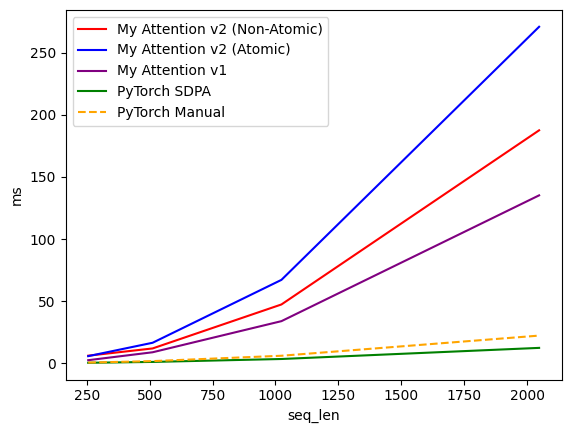

In [ ]:
import triton.testing

# Manual PyTorch implementation (The "Naive" approach)
def manual_attention(q, k, v, sm_scale):
    scores = torch.matmul(q, k.transpose(-2, -1)) * sm_scale
    probs = F.softmax(scores, dim=-1)
    output = torch.matmul(probs, v)
    return output

@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['seq_len'],  # Argument to vary (Sequence Length)
        x_vals=[2**x for x in range(8, 12)], # Sequence lengths to test
        line_arg='provider',
        line_vals=['triton_v2_nonatomic', 'triton_v2_atomic', 'triton_v1', 'torch_sdpa', 'torch_manual'],
        line_names=['My Attention v2 (Non-Atomic)','My Attention v2 (Atomic)','My Attention v1', 'PyTorch SDPA', 'PyTorch Manual'],
        styles=[('red', '-'), ('blue', '-'),  ('purple', '-'), ('green', '-'), ('orange', '--')],
        ylabel='ms',
        plot_name='attn-performance',
        args={'BATCH': 4, 'HEADS': 8, 'D_HEAD': 64, 'mode': 'fwd_bwd'}#<---- change the arguement for forward and backward respectively
    )
)
def benchmark(seq_len, BATCH, HEADS, D_HEAD, mode, provider):
    dtype = torch.float16
    device = "cuda"

    q = torch.randn((BATCH, HEADS, seq_len, D_HEAD), dtype=dtype, device=device, requires_grad=True)
    k = torch.randn((BATCH, HEADS, seq_len, D_HEAD), dtype=dtype, device=device, requires_grad=True)
    v = torch.randn((BATCH, HEADS, seq_len, D_HEAD), dtype=dtype, device=device, requires_grad=True)

    sm_scale = 1.0 / (D_HEAD ** 0.5)

    # 2. Define the closure
    if provider == 'torch_manual':
        if seq_len > 2**12:
            return float('inf'), float('inf'), float('inf')
        def fn():
            out = manual_attention(q, k, v, sm_scale)
            if mode == 'fwd_bwd':
                out.backward(torch.randn_like(out))

    if provider == 'torch_sdpa':
        def fn():
             out = F.scaled_dot_product_attention(q, k, v, scale=sm_scale)
             if mode == 'fwd_bwd':
                out.backward(torch.randn_like(out))

    if provider == 'triton_v1':
        def fn():
            out = Myattention1.apply(q, k, v, False)
            if mode == 'fwd_bwd':
                out.backward(torch.randn_like(out))

    if provider == 'triton_v2_atomic':
        def fn():
            out = Myattention2.apply(q, k, v, False)
            if mode == 'fwd_bwd':
                out.backward(torch.randn_like(out))

    if provider == 'triton_v2_nonatomic':
        def fn():
            out = MyattentionV2.apply(q, k, v, False)
            if mode == 'fwd_bwd':
                out.backward(torch.randn_like(out))

    # Run Benchmark
    ms = triton.testing.do_bench(fn, warmup=25, rep=100)

    return ms

if __name__ == '__main__':
    #pd.options.display.float_format = None
    #torch.cuda.empty_cache()
    benchmark.run(print_data=True, show_plots=False, save_path='.')

**Now you might be wondering how come all the custom kernel take sooooo much time but wait check the results below**

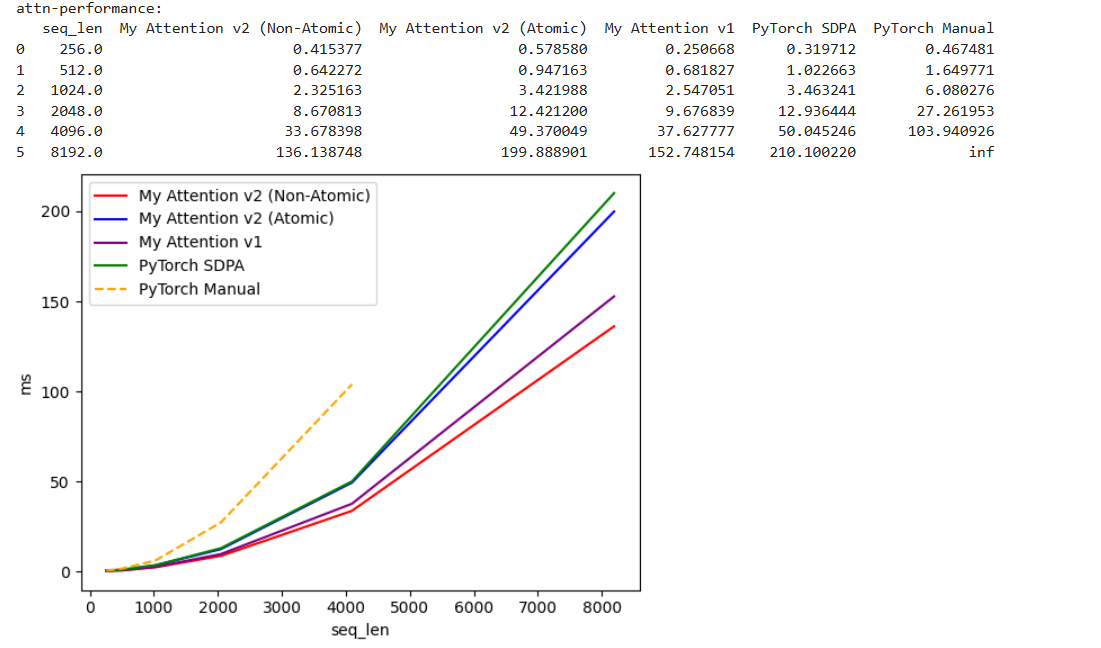

I dont understand why huge score diff the above has been tested on kaggle t4 gpu
1. Possible theory I have is clock speed has been lowerd in colab t4 gpu

**If somebody knows a workaround let me know but I hope you learned a lot from this kernel :)**